In [98]:
# import standard libraries
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt

# import preproccessing modules
import re
from nltk.corpus import stopwords
import string
from urllib.parse import urlparse

# import functionality for naive bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [99]:
# import training data
with open("../data/training_data", "rb") as fb:
    training_data = pickle.load(fb)

# import testing data
with open("../data/testing_data", "rb") as fb:
    testing_data = pickle.load(fb)

In [100]:
min = -1
training_data = training_data.loc[training_data.score > min]
testing_data = testing_data.loc[testing_data.score > min]

In [101]:
req_cols = ["url", "title", "text", "time", "score"]
training_data = training_data.loc[training_data.type == "story"]
training_data = training_data[req_cols].reset_index(drop = True)

testing_data = testing_data.loc[testing_data.type == "story"]
testing_data = testing_data[req_cols].reset_index(drop = True)

In [102]:
cutoff = 20

training_data["score"] = (training_data["score"] > cutoff).astype(int)
testing_data["score"] = (testing_data["score"] > cutoff).astype(int)

In [103]:
training_data["url"] = training_data["url"].fillna("")
training_data["title"] = training_data["title"].fillna("")
training_data["text"] = training_data["text"].fillna("")


testing_data["url"] = testing_data["url"].fillna("")
testing_data["title"] = testing_data["title"].fillna("")
testing_data["text"] = testing_data["text"].fillna("")

In [104]:
training_data

,url,title,text,time,score
0,https://betco.in,Not sure if this is legal for US citizens but ...,,1.304883e+09,0
1,http://www.theguardian.com/us-news/2015/aug/15...,What happens to Americans who film police viol...,,1.439662e+09,0
2,http://www.bigdata-startups.com/BigData-startu...,Big data startup Gainsight uses big data to im...,,1.368459e+09,0
3,https://www.sciencebasedmedicine.org/how-to-li...,How to Listen to Chi,,1.436895e+09,0
4,http://arstechnica.com/tech-policy/news/2011/0...,Google faces $50 million lawsuit over Android ...,,1.305303e+09,0
...,...,...,...,...,...
432533,http://www.theregister.co.uk/2009/02/11/feinst...,US lawmaker injects ISP throttle into Obama re...,,1.234388e+09,0
432534,https://www.usenix.org/legacy/publications/lib...,Failure-Oblivious Computing (2004) [pdf],,1.446683e+09,0
432535,http://www.huffingtonpost.com/tim-chartier/mat...,Everything I Needed to Know I Learned in Math ...,,1.338758e+09,0
432536,https://twitter.com/#!/chanian,Twitter employee live tweets WSOP from the table,,1.341296e+09,0


We want to calculate the probablity of a post being either popular or not popular (1 or 0)

To do this we want to get the argmax of P(C|post)

P(C|post) = P(C) * P(post | C)

P(post | C) = MUL P(x | C) for atribute x in post

x consists of:
   - words in url
   - words in title
   - words in text
   - time


For the words, we use a model in which we count the number of occurances of each word (in total, and within each class)

For time, we can use a Gaussian Naive Bayes model


In [105]:
p_popular = (training_data.score.sum()) / len(training_data)
p_not_popular = 1 - p_popular

print(p_popular, p_not_popular)

0.08557167231549598 0.914428327684504


In [106]:
stop_words = set(stopwords.words('english'))

def preproccess(text):

    tokens = re.split('\s+', text)
    tokens = ["".join([i for i in x if i not in string.punctuation]) for x in tokens]
    tokens = [re.sub("\d+", "", x) for x in tokens]
    tokens = [x.lower() for x in tokens]
    tokens = [token for token in tokens if len(token) > 2]
    final = [word for word in tokens if word not in stop_words]
    final = "".join(x + " " for x in final)

    return final

In [107]:
training_data["title"] = training_data["title"].apply(lambda x: preproccess(x))
training_data["text"] = training_data["text"].apply(lambda x: preproccess(x))

testing_data["title"] = testing_data["title"].apply(lambda x: preproccess(x))
testing_data["text"] = testing_data["text"].apply(lambda x: preproccess(x))

In [108]:
training_data["time"] = training_data["time"].fillna(-1)
testing_data["time"] = testing_data["time"].fillna(-1)

training_data["time"] = training_data["time"].apply(lambda x: [x])
testing_data["time"] = testing_data["time"].apply(lambda x: [x])

In [109]:
training_data["url"] = training_data["url"].apply(lambda x: urlparse(x).netloc)
testing_data["url"] = testing_data["url"].apply(lambda x: urlparse(x).netloc)

In [110]:
titles_model = make_pipeline(CountVectorizer(), MultinomialNB())
texts_model = make_pipeline(CountVectorizer(), MultinomialNB())
combined_model1 = make_pipeline(CountVectorizer(), MultinomialNB())

url_model = make_pipeline(CountVectorizer(), MultinomialNB())
combined_model2 = make_pipeline(CountVectorizer(), MultinomialNB())

time_model = make_pipeline(GaussianNB())

In [111]:
titles_model.fit(training_data["title"], training_data["score"])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [112]:
texts_model.fit(training_data["text"], training_data["score"])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [113]:
combined_model1.fit(training_data["text"] + " " + training_data["text"], training_data["score"])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [114]:
url_model.fit(training_data["url"], training_data["score"])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [115]:
combined_model2.fit(training_data["text"] + " " + training_data["text"] + " " + training_data["url"], training_data["score"])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [116]:
predictions1 = titles_model.predict(testing_data["title"])
predictions2 = texts_model.predict(testing_data["text"])
predictions3 = combined_model1.predict(testing_data["title"] + " " + testing_data["text"])
predictions4 = url_model.predict(testing_data["url"])
predictions5 = combined_model2.predict(testing_data["title"] + " " + testing_data["text"] + " " + testing_data["url"])

In [117]:
scores = testing_data["score"].fillna(0)
conf_mat_1 = confusion_matrix(scores, predictions1)
conf_mat_2 = confusion_matrix(scores, predictions2)
conf_mat_3 = confusion_matrix(scores, predictions3)
conf_mat_4 = confusion_matrix(scores, predictions4)
conf_mat_5 = confusion_matrix(scores, predictions5)

In [118]:
from sklearn import metrics

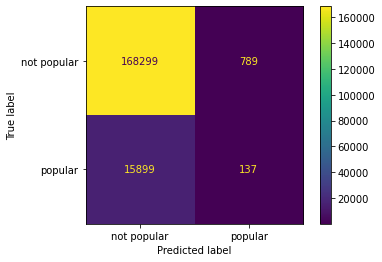

In [119]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat_1, display_labels = ["not popular", "popular"])
display.plot()
plt.show()

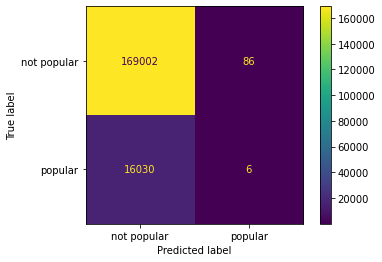

In [120]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat_2, display_labels = ["not popular", "popular"])
display.plot()
plt.show()

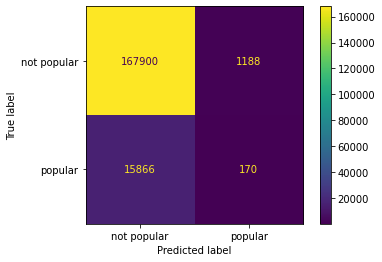

In [121]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat_3, display_labels = ["not popular", "popular"])
display.plot()
plt.show()

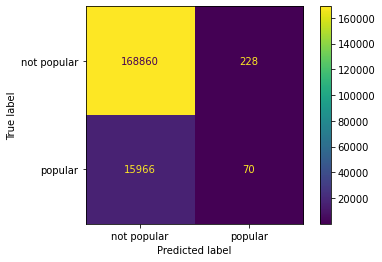

In [122]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat_4, display_labels = ["not popular", "popular"])
display.plot()
plt.show()

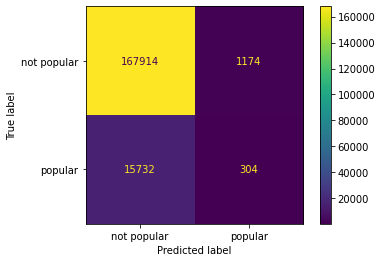

In [123]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat_5, display_labels = ["not popular", "popular"])
display.plot()
plt.show()